Повторяю препроцессинг отсюда [https://www.mdpi.com/1099-4300/19/9/488], denoising сигнала объяснен тут [https://sci-hub.se/10.1016/j.bspc.2013.01.005]

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import decimate
import pywt
import scipy

In [2]:
def load_record(record_name):
    path = os.path.join("../train/", record_name + ".npy")
    record = np.load(path)
    return record


In [3]:
record = load_record("00009_hr")
record.shape

(12, 5000)

db6 wavelet был выбран, потому что во всех папирах его выбирают, везде ссылаются на это исследование[]

In [4]:
meow = pywt.Wavelet("db6")

In [5]:
pywt.dwt_max_level(len(record[0]), meow) 

8

In [6]:
def denoise(record, noise_level):
    """
        record - оригинальный экг сигнал.
        noise_levels - до какого уровня wavelet decomposition включительно считать шумом.
    """
    db6 = pywt.Wavelet("db6")
    # имеет вид [cA_n, c_Dn, ... , C_D1], 
    # где cA_n - aproximation coefficients последнего уровня, они нам не нужны, cD_n - detail coefficients n уровня.
    coefs = pywt.wavedec(record, db6, axis=-1)
    # убираем aproximation coeficients
    coefs[0] = np.zeros_like(coefs[0])
    # обнуляем начальные левелы, так написано в папире про денойзинг, 
    # так как экг сигнал с частотой >45 hz имеет мало информации
    for i in range(1, noise_level+1):
        coefs[-i] = np.zeros_like(coefs[-i])
    denoised = pywt.waverec(coefs, meow)
    return denoised

In [7]:
def plot(signal):
    plt.figure(dpi=200)
    plt.figure(figsize=(20, 8))
    plt.plot(range(len(signal[0])), signal[0])  # Plot some data on the axes.

<Figure size 1280x960 with 0 Axes>

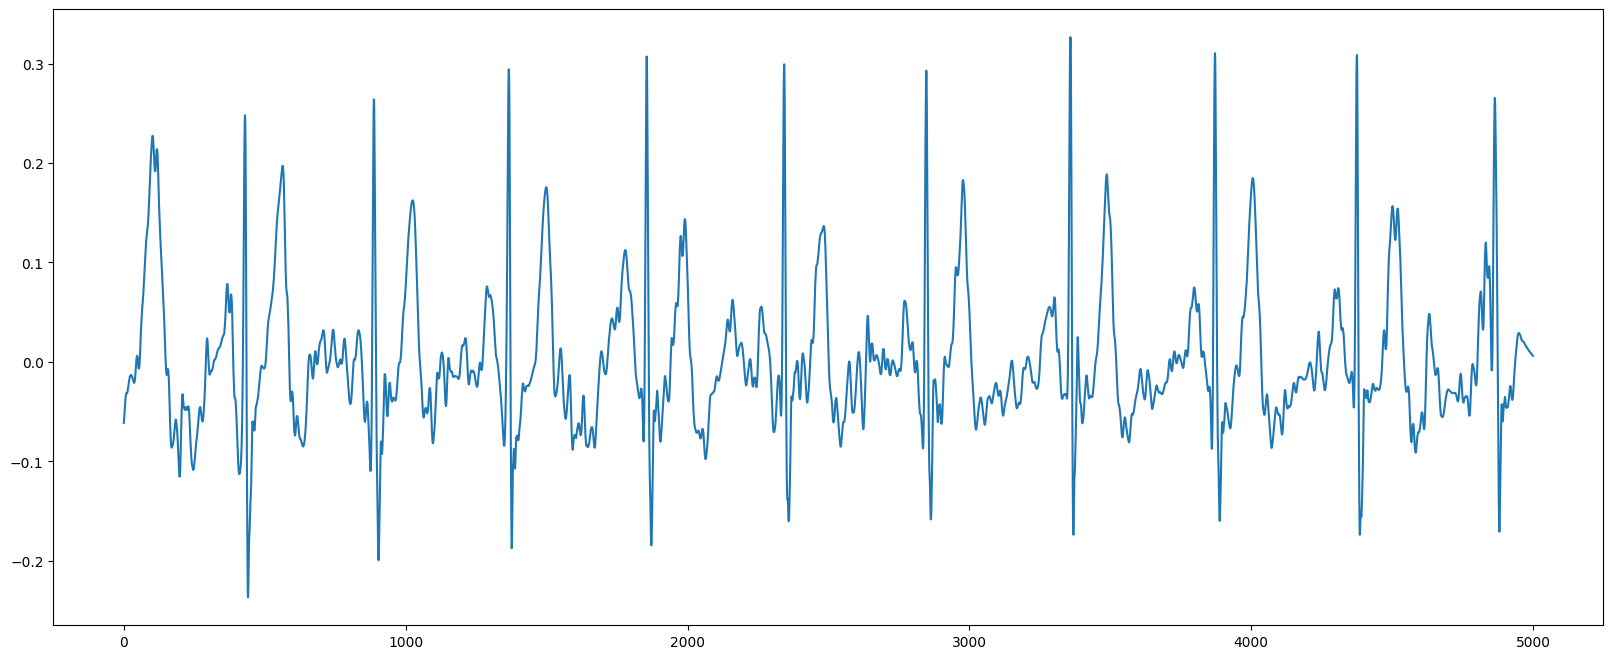

In [8]:
plot(denoise(record, 3))

<Figure size 1280x960 with 0 Axes>

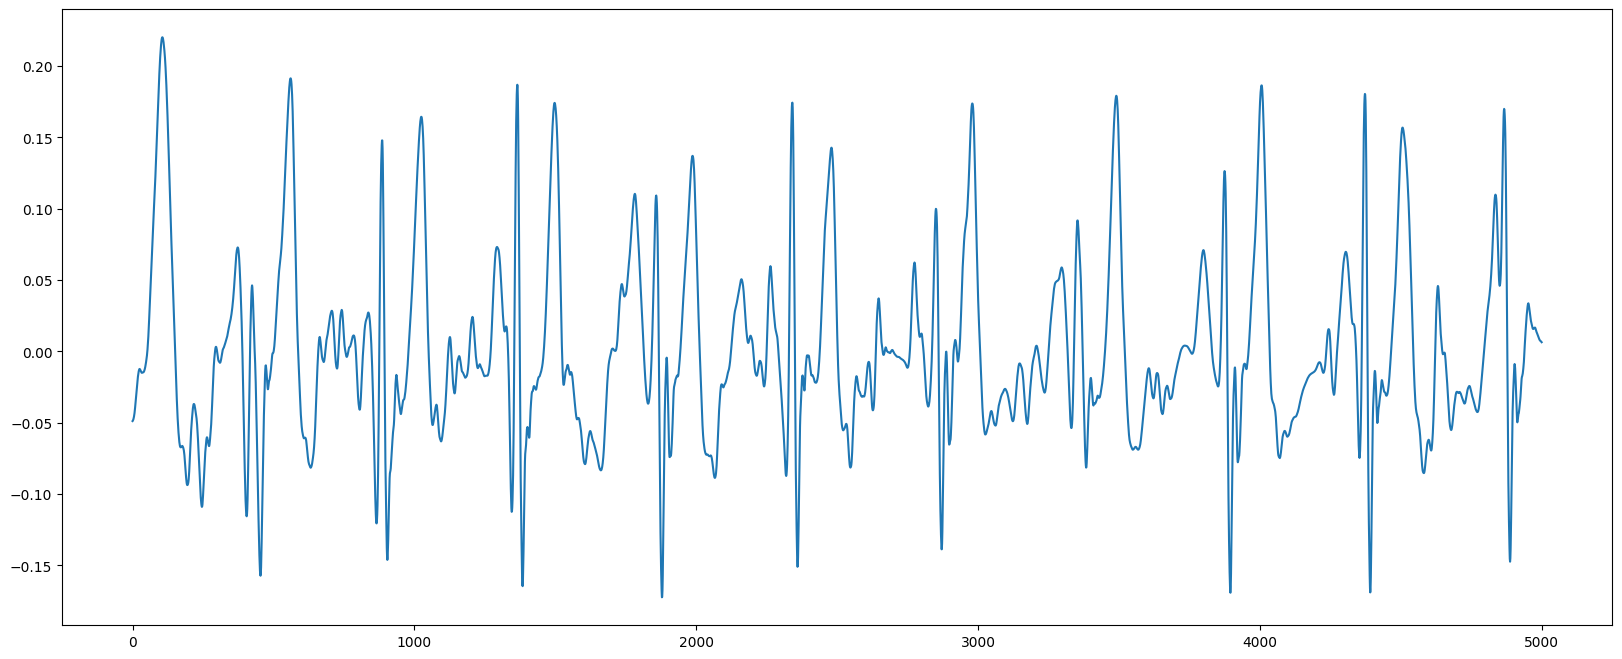

In [9]:

plot(denoise(record, 4))

In [10]:
from pipeline_beat_extraction import PipelineBeatExtraction
# Find the R peak locations
pipeline = PipelineBeatExtraction('./../train/')
beats = pipeline.run_pipeline("00009_hr")


/home/biba/Documents/programming/aiijc/medicine/preprocessing_with_beats/preprocessing_beat.py:532: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results.append(np.asarray(curr_beats))


In [11]:
beats.shape

(12, 9)

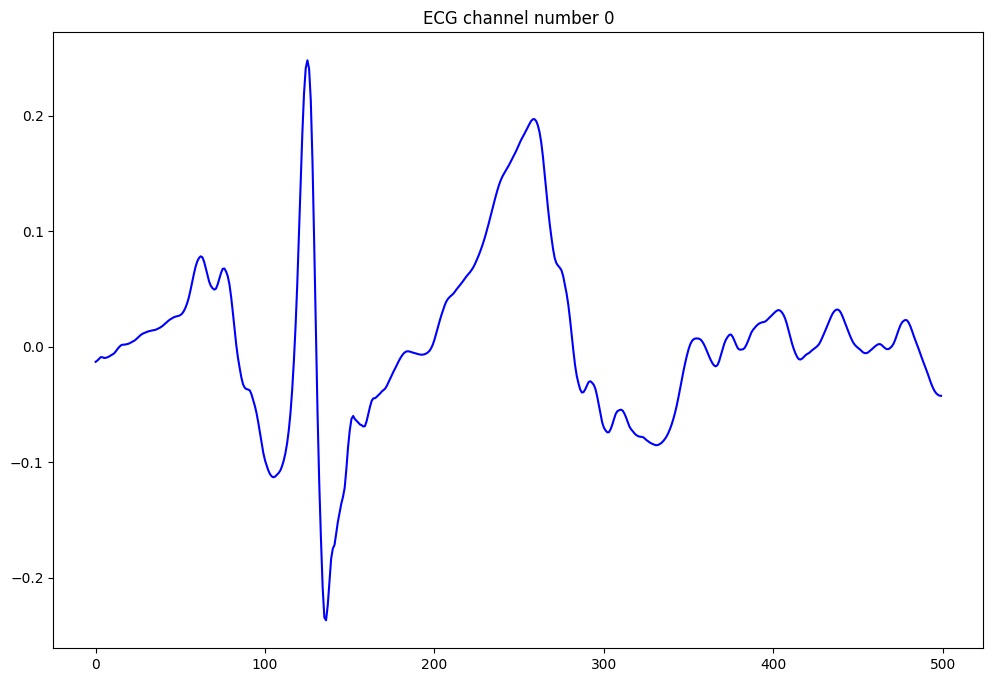

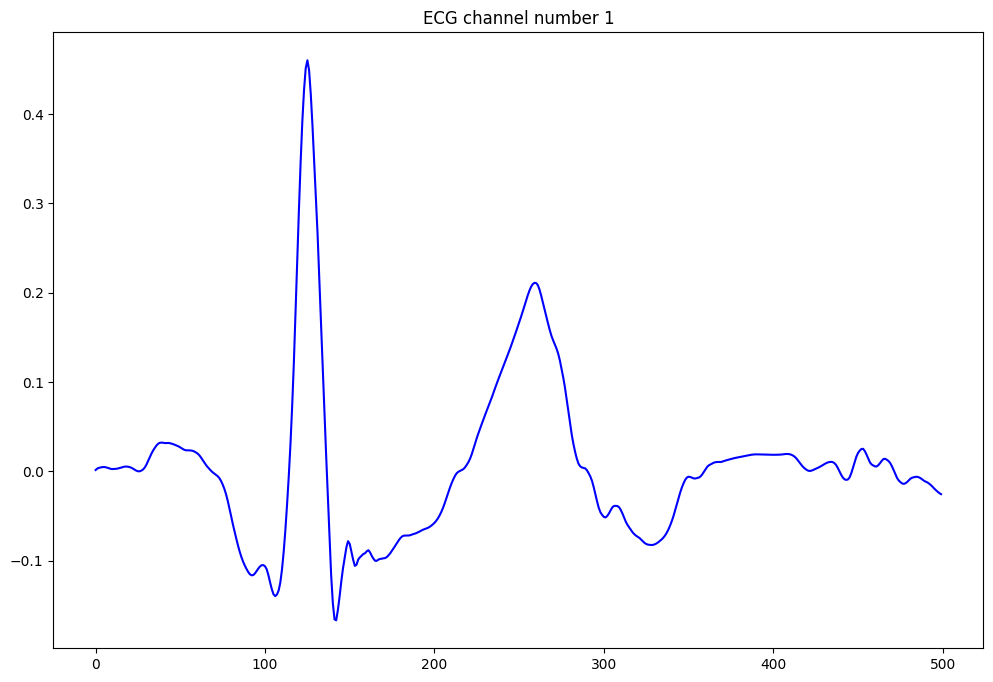

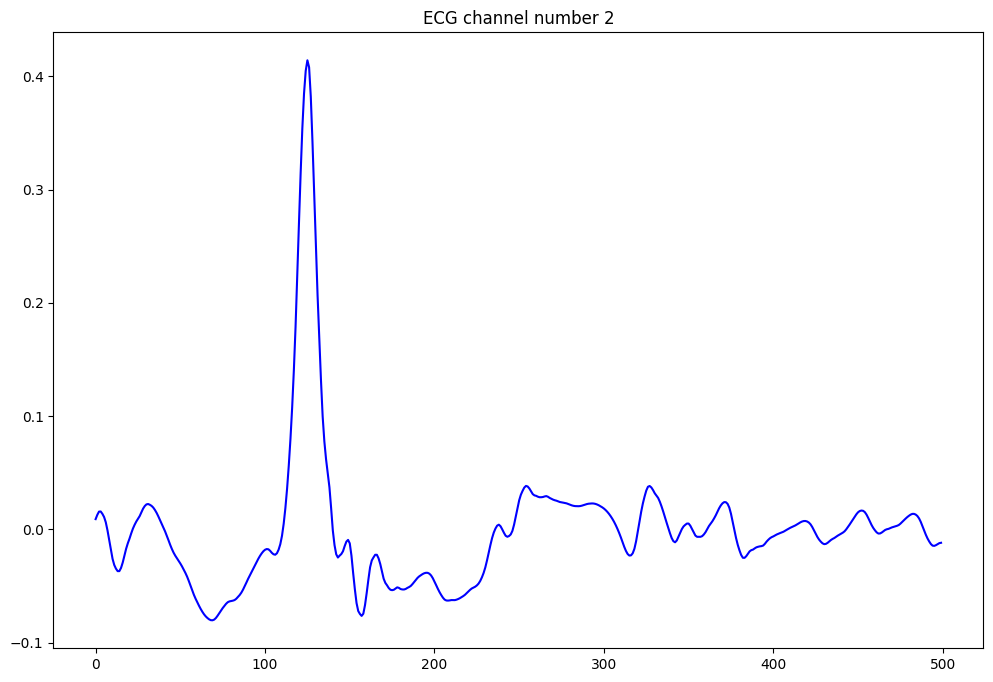

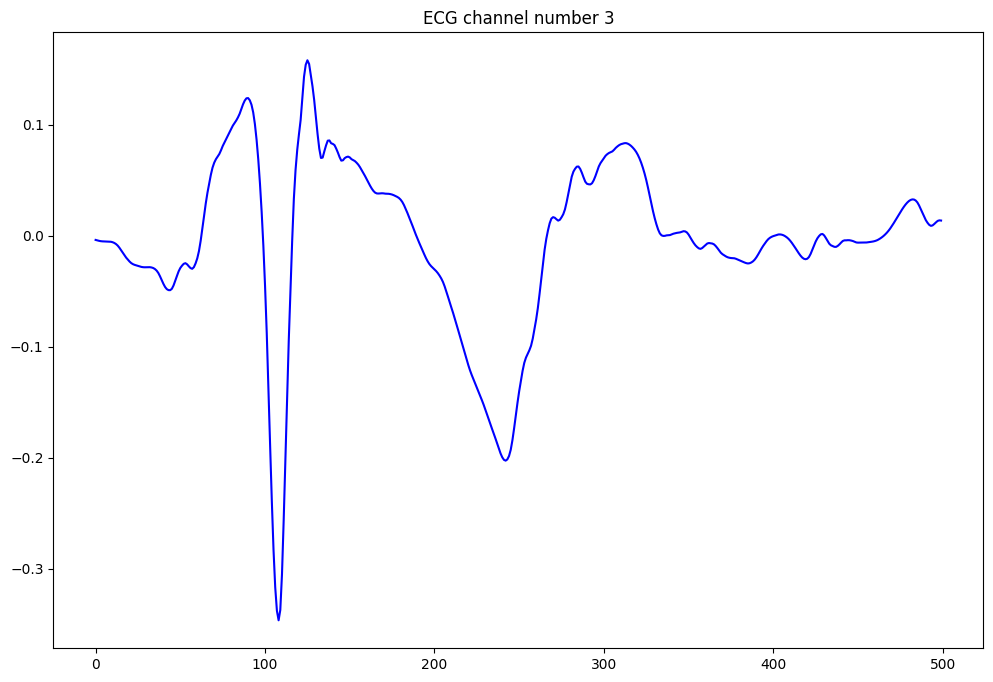

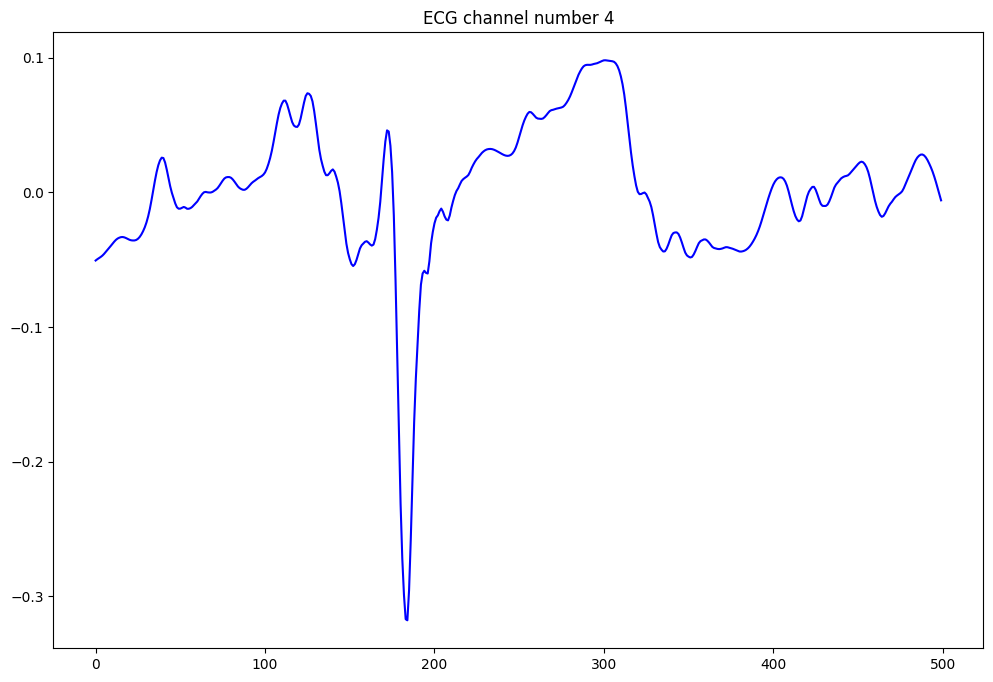

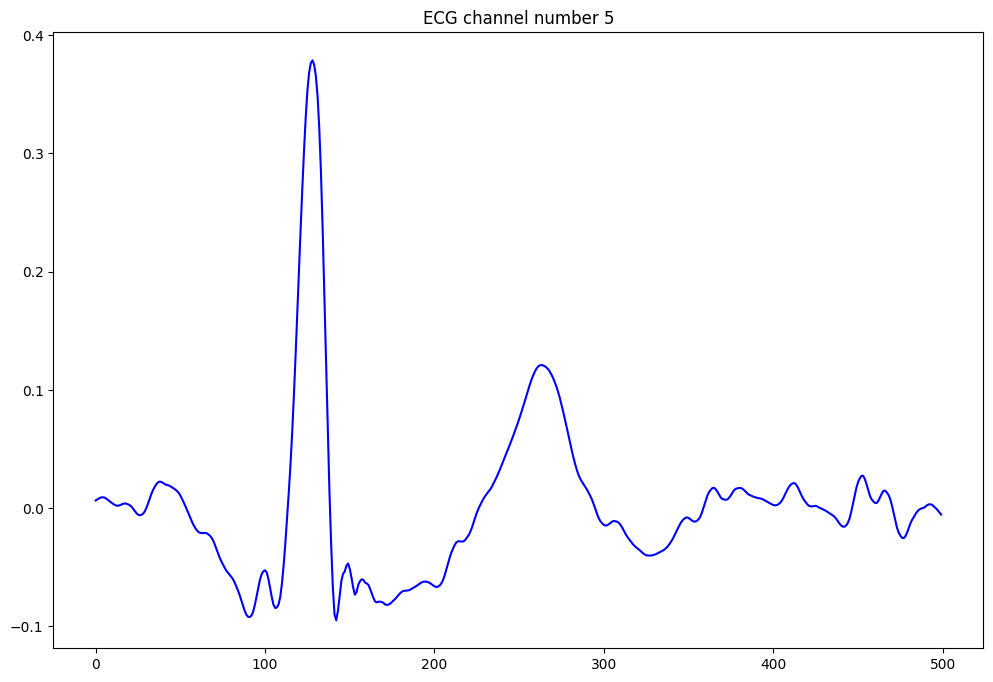

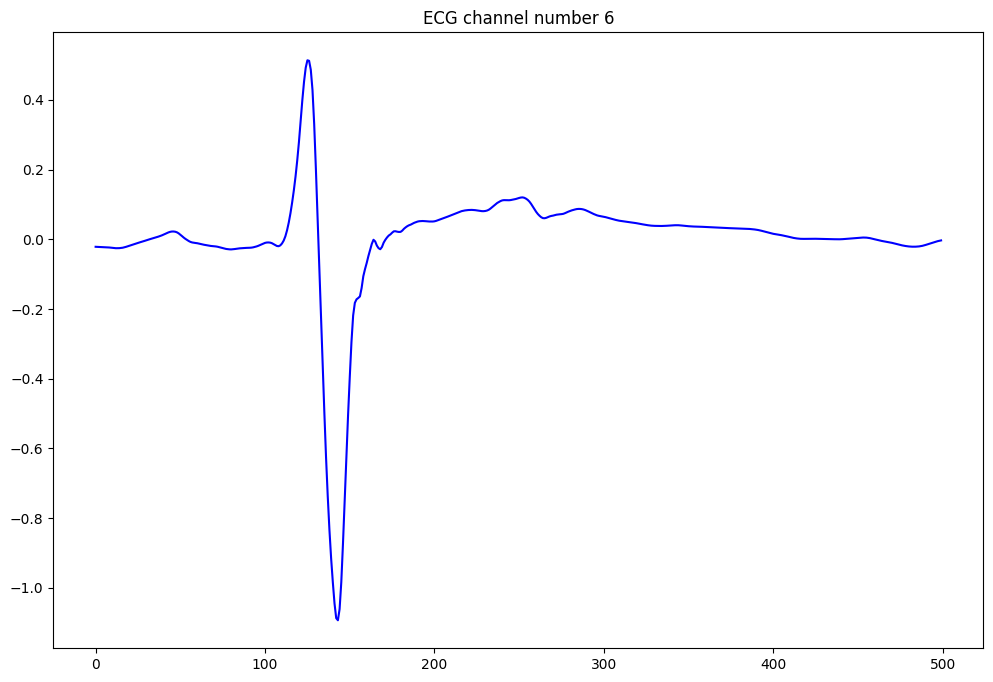

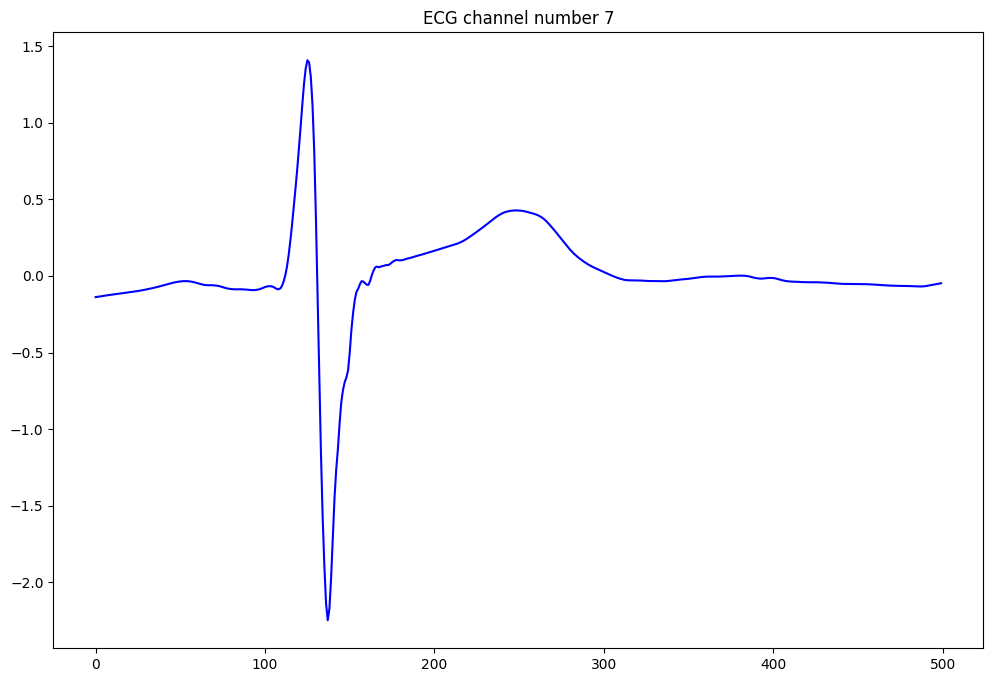

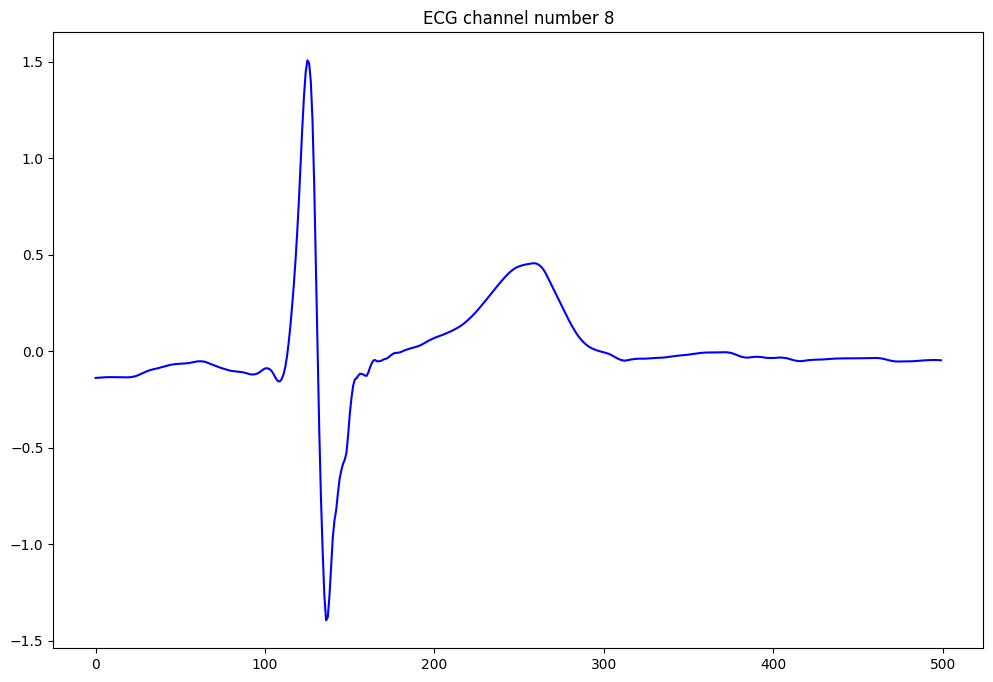

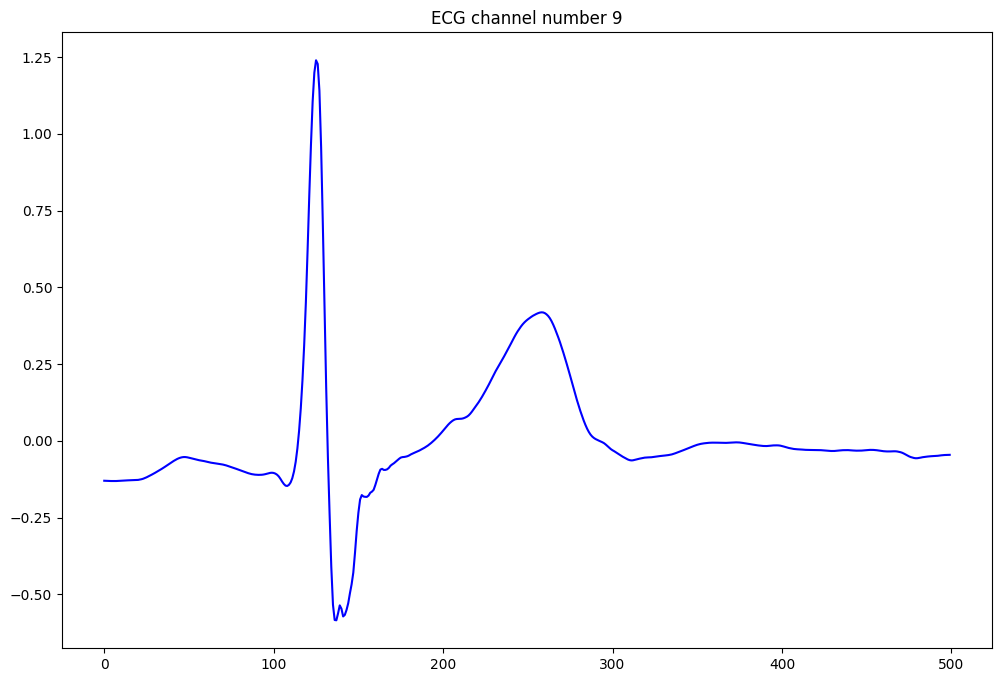

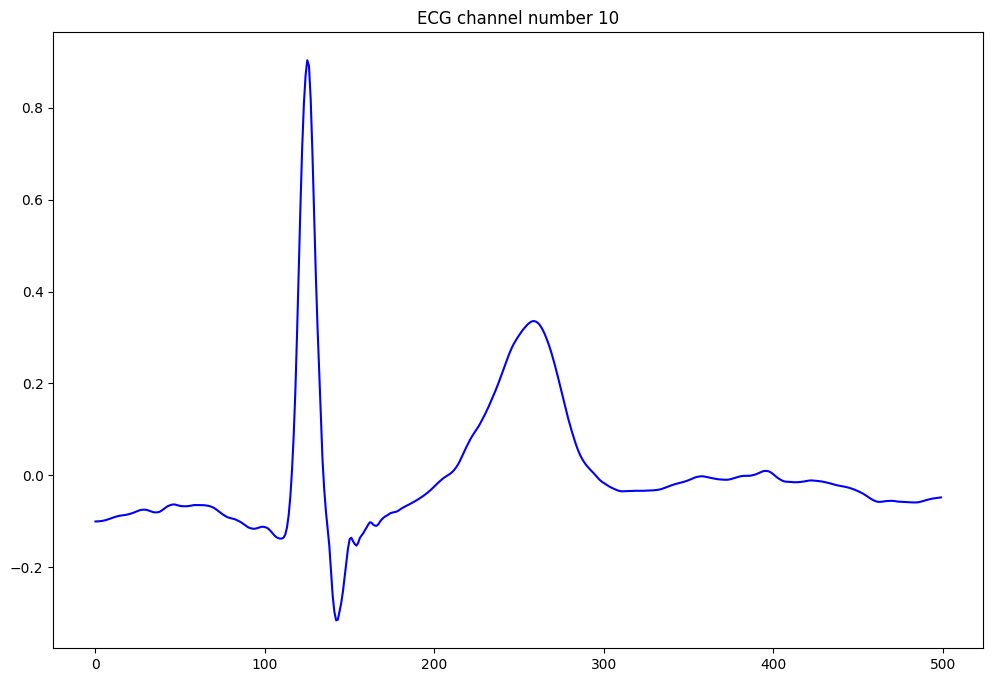

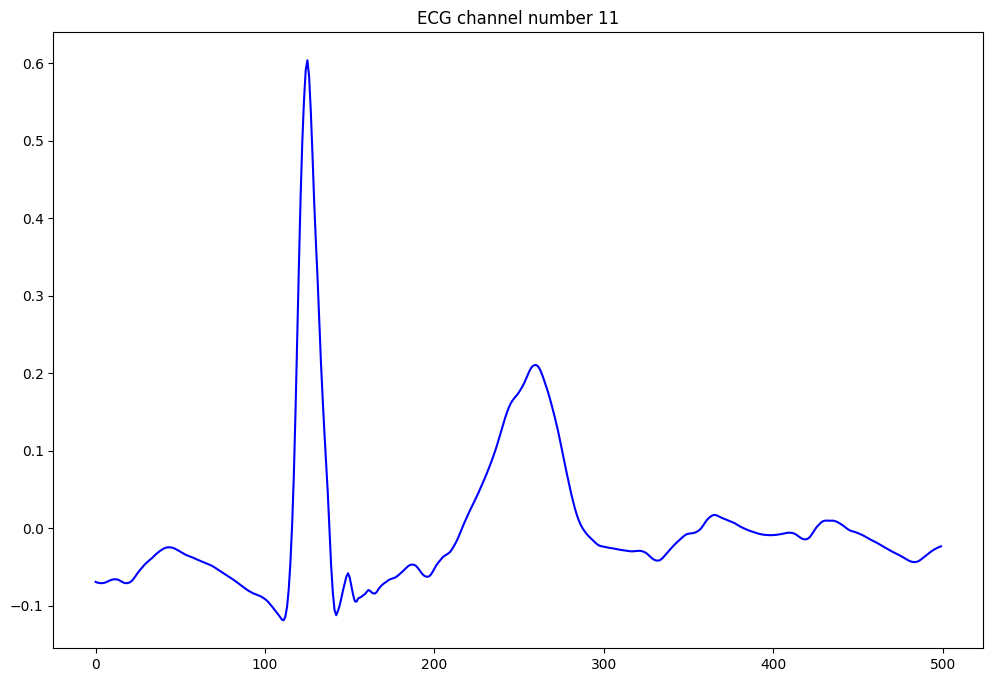

In [12]:
for ecg_channel in range(12):
    for beat in beats[ecg_channel][:1]:
        plt.figure(figsize=(12, 8), dpi=100)
        plt.title(f"ECG channel number {ecg_channel}")
        plt.plot(beat, color='blue')
